# Лабораторная №2. Перенос знаний

### Imports

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Data

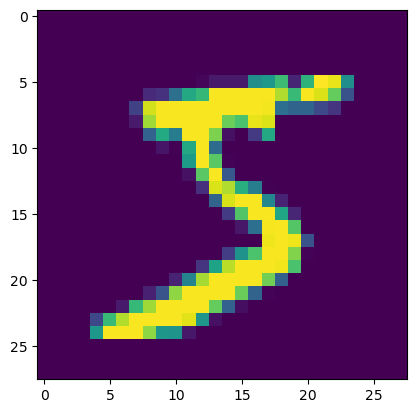

In [91]:
batch_size = 100
loss_function= nn.CrossEntropyLoss()

train_data = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
plt.imshow(train_data[0][0].permute(1, 2, 0))
plt.show()

### Model

In [92]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc =  nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


#### Train model

In [93]:
def test_model(model, test_loader):
    correct_cnt = 0
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predicted = output.data.max(1)[1]
            correct_cnt += (predicted == target).sum().item()
    accuracy = correct_cnt / len(test_loader.dataset)
    return accuracy

def train_model(model, optimizer, train_loader, test_loader, epoches=5):
    train_accuracy = []
    test_accuracy = []
    train_loss = []
    model.train()
    for epoch in range(epoches):
        print(f"epoch {epoch+1}/{epoches}")
        for batch, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output,target)
            loss.backward()
            train_loss.append(loss.data.item())
            optimizer.step()
            prediction = output.data.max(1)[1]  
            accuracy = prediction.eq(target.data).sum()/batch_size
            train_accuracy.append(accuracy)
            if (batch+1) % 100 == 0:
                test_ac = test_model(model,test_loader)
                model.train()
                test_accuracy.append(test_ac)
                print(f"step {batch+1}/{len(train_loader)}\tloss {loss.item():.4f}\ttrain_accuracy {accuracy:.2f}\ttest_accuracy {test_ac:.2f}")
    return train_accuracy, train_loss, test_accuracy


In [94]:
def plot_learning_curve(train_accuracy, train_loss, test_accuracy, window_size = 100):
    fig, (ax0, ax1) = plt.subplots(2,1)
    fig.set_size_inches(10,10)
    ax0.set_title("Accuracy")
    ax0.plot(pd.Series(train_accuracy).rolling(window_size).mean(), label=f"Rolling average for accuracy with window size = {window_size}")
    ax0.plot(range(batch_size,len(train_accuracy)+1,batch_size), test_accuracy, label=f"Accuracy on test data")
    ax0.legend()
    ax1.set_title(f"Rolling average for cross entropy loss with window size = {window_size}")
    ax1.plot(pd.Series(train_loss).rolling(window_size).mean())
    plt.show()

In [95]:
def test_plus_plot(model, test_loader, train_accuracy, train_loss, test_accuracy):
    print(f'Accuracy on test data: {test_model(model,test_loader)}')
    plot_learning_curve(train_accuracy, train_loss, test_accuracy)

### Test 1. MNIST 

In [96]:
model = MnistModel()
train_ac, train_loss, test_ac = train_model(model, optim.Adam(model.parameters(), lr=0.001), train_loader, test_loader,3)

epoch 1/3
step 100/600	loss 0.1579	train_accuracy 0.94	test_accuracy 0.95
step 200/600	loss 0.1032	train_accuracy 0.98	test_accuracy 0.97
step 300/600	loss 0.0568	train_accuracy 0.98	test_accuracy 0.98
step 400/600	loss 0.0332	train_accuracy 0.99	test_accuracy 0.98
step 500/600	loss 0.0509	train_accuracy 0.99	test_accuracy 0.98
step 600/600	loss 0.0429	train_accuracy 0.98	test_accuracy 0.99
epoch 2/3
step 100/600	loss 0.0532	train_accuracy 0.97	test_accuracy 0.98
step 200/600	loss 0.0605	train_accuracy 0.98	test_accuracy 0.99
step 300/600	loss 0.0349	train_accuracy 0.98	test_accuracy 0.99
step 400/600	loss 0.0685	train_accuracy 0.97	test_accuracy 0.99
step 500/600	loss 0.0180	train_accuracy 1.00	test_accuracy 0.99
step 600/600	loss 0.0692	train_accuracy 0.98	test_accuracy 0.99
epoch 3/3
step 100/600	loss 0.0033	train_accuracy 1.00	test_accuracy 0.99
step 200/600	loss 0.0299	train_accuracy 0.99	test_accuracy 0.99
step 300/600	loss 0.0080	train_accuracy 1.00	test_accuracy 0.99
step 400/6

Accuracy on test data: 0.9907


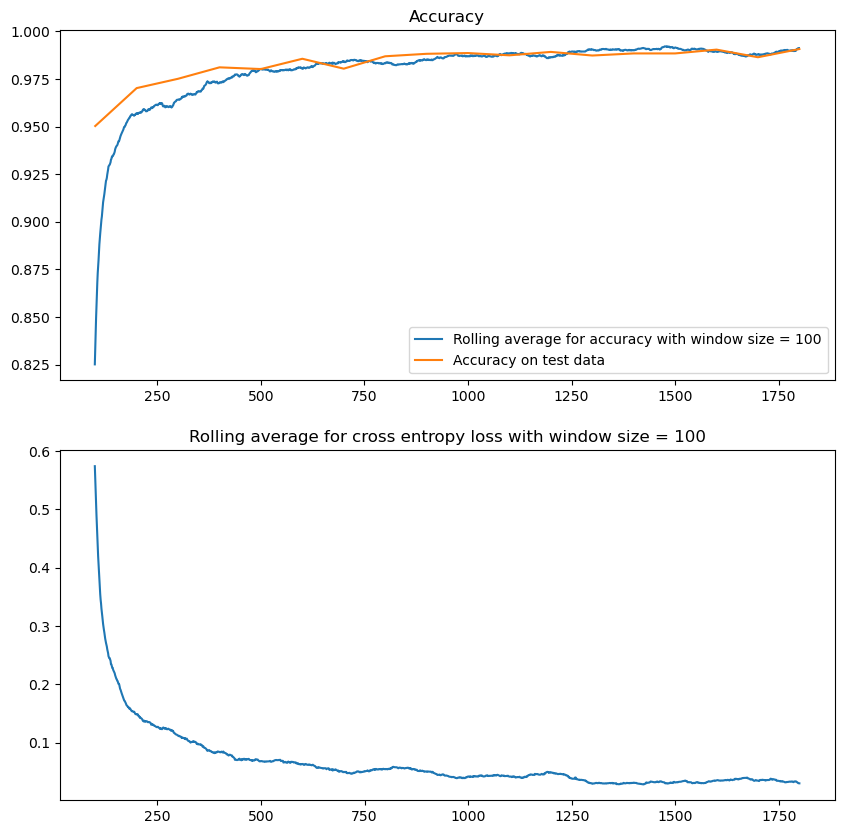

In [97]:
test_plus_plot(model,test_loader,train_ac,train_loss,test_ac)
mnist_params = model.state_dict()

### Test 2. Fashion-MNIST

In [98]:
train_data = datasets.FashionMNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.FashionMNIST(root="data", train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
model = MnistModel()
train_ac_fashion, train_loss_fashion, test_ac_fashion = train_model(model, optim.Adam(model.parameters(), lr=0.0005), train_loader, test_loader)

epoch 1/5
step 100/600	loss 0.6440	train_accuracy 0.76	test_accuracy 0.75
step 200/600	loss 0.7333	train_accuracy 0.69	test_accuracy 0.81
step 300/600	loss 0.5976	train_accuracy 0.75	test_accuracy 0.83
step 400/600	loss 0.4590	train_accuracy 0.81	test_accuracy 0.85
step 500/600	loss 0.5402	train_accuracy 0.79	test_accuracy 0.84
step 600/600	loss 0.4304	train_accuracy 0.84	test_accuracy 0.86
epoch 2/5
step 100/600	loss 0.3171	train_accuracy 0.87	test_accuracy 0.86
step 200/600	loss 0.2102	train_accuracy 0.92	test_accuracy 0.87
step 300/600	loss 0.3541	train_accuracy 0.83	test_accuracy 0.87
step 400/600	loss 0.2478	train_accuracy 0.91	test_accuracy 0.87
step 500/600	loss 0.2634	train_accuracy 0.94	test_accuracy 0.88
step 600/600	loss 0.2405	train_accuracy 0.90	test_accuracy 0.88
epoch 3/5
step 100/600	loss 0.2241	train_accuracy 0.92	test_accuracy 0.88
step 200/600	loss 0.2922	train_accuracy 0.90	test_accuracy 0.88
step 300/600	loss 0.3904	train_accuracy 0.87	test_accuracy 0.89
step 400/6

Accuracy on test data: 0.9066


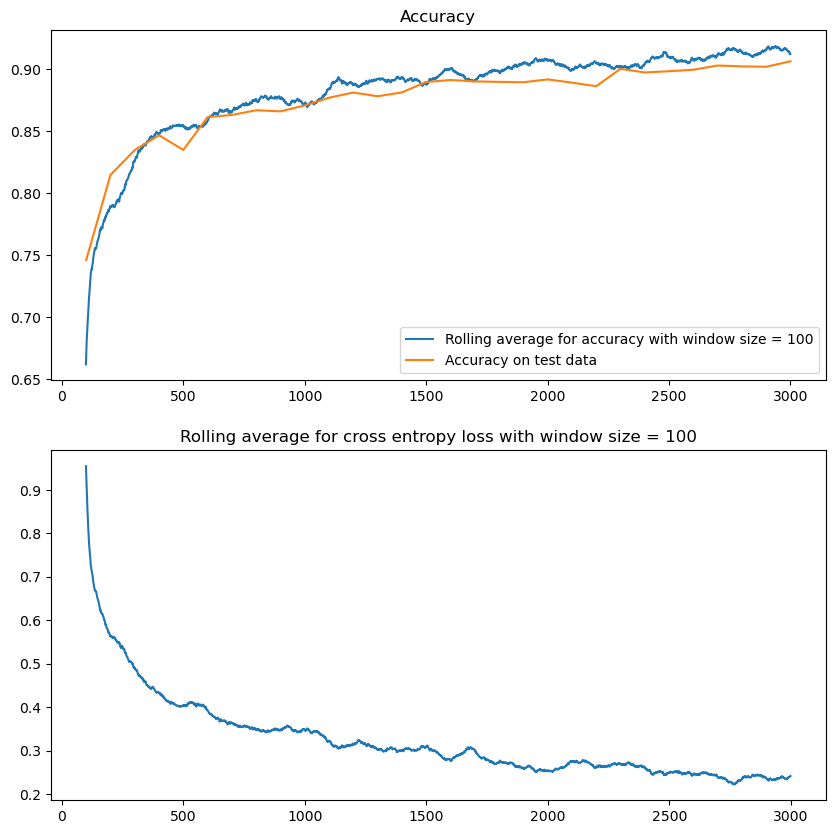

In [99]:
test_plus_plot(model,test_loader,train_ac_fashion,train_loss_fashion,test_ac_fashion)

### Test 3. Fashion-MNIST with copied parametres

In [100]:
model = MnistModel()
model.load_state_dict(mnist_params)
train_ac_fashion_copied, train_loss_fashion_copied, test_ac_fashion_copied = train_model(model, optim.Adam(model.parameters(), lr=0.001), train_loader, test_loader)

epoch 1/5
step 100/600	loss 0.4885	train_accuracy 0.80	test_accuracy 0.83
step 200/600	loss 0.3744	train_accuracy 0.88	test_accuracy 0.84
step 300/600	loss 0.3324	train_accuracy 0.89	test_accuracy 0.86
step 400/600	loss 0.4070	train_accuracy 0.86	test_accuracy 0.86
step 500/600	loss 0.3436	train_accuracy 0.86	test_accuracy 0.88
step 600/600	loss 0.2868	train_accuracy 0.93	test_accuracy 0.88
epoch 2/5
step 100/600	loss 0.2494	train_accuracy 0.90	test_accuracy 0.89
step 200/600	loss 0.1930	train_accuracy 0.93	test_accuracy 0.89
step 300/600	loss 0.1851	train_accuracy 0.92	test_accuracy 0.89
step 400/600	loss 0.2409	train_accuracy 0.90	test_accuracy 0.90
step 500/600	loss 0.2197	train_accuracy 0.93	test_accuracy 0.90
step 600/600	loss 0.2781	train_accuracy 0.91	test_accuracy 0.90
epoch 3/5
step 100/600	loss 0.1855	train_accuracy 0.91	test_accuracy 0.90
step 200/600	loss 0.2414	train_accuracy 0.88	test_accuracy 0.90
step 300/600	loss 0.2331	train_accuracy 0.88	test_accuracy 0.89
step 400/6

Accuracy on test data: 0.9145


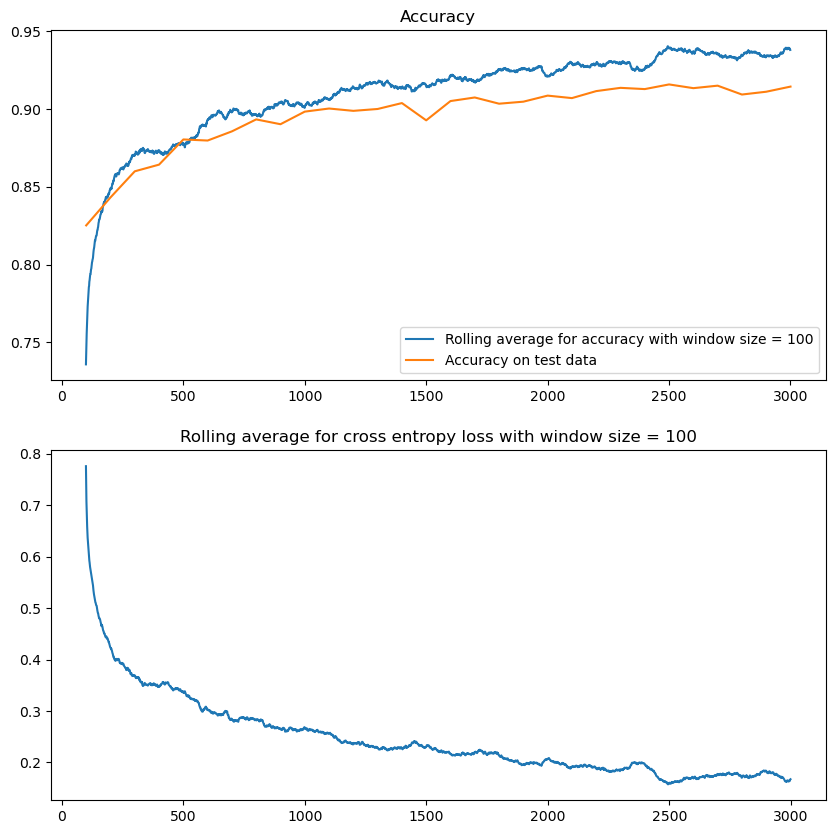

In [101]:
test_plus_plot(model,test_loader,train_ac_fashion_copied,train_loss_fashion_copied,test_ac_fashion_copied)

### Test 4. Fashion-MNIST with frozen parametres on convolutional layer

In [102]:
model = MnistModel()
model.conv1.requires_grad_(False)
model.conv2.requires_grad_(False)
unfrozen_parametres = filter(lambda p: p.requires_grad, model.parameters())

model.load_state_dict(mnist_params)

train_ac_frozen, train_loss_frozen, test_ac_frozen = train_model(model, optim.Adam(unfrozen_parametres, lr=0.001), train_loader, test_loader, 3)

epoch 1/3
step 100/600	loss 0.5927	train_accuracy 0.79	test_accuracy 0.82
step 200/600	loss 0.6494	train_accuracy 0.81	test_accuracy 0.85
step 300/600	loss 0.5904	train_accuracy 0.81	test_accuracy 0.85
step 400/600	loss 0.2228	train_accuracy 0.94	test_accuracy 0.87
step 500/600	loss 0.3205	train_accuracy 0.90	test_accuracy 0.87
step 600/600	loss 0.3657	train_accuracy 0.89	test_accuracy 0.88
epoch 2/3
step 100/600	loss 0.3281	train_accuracy 0.89	test_accuracy 0.88
step 200/600	loss 0.2757	train_accuracy 0.90	test_accuracy 0.88
step 300/600	loss 0.2719	train_accuracy 0.89	test_accuracy 0.88
step 400/600	loss 0.3740	train_accuracy 0.86	test_accuracy 0.87
step 500/600	loss 0.2456	train_accuracy 0.92	test_accuracy 0.88
step 600/600	loss 0.2774	train_accuracy 0.91	test_accuracy 0.89
epoch 3/3
step 100/600	loss 0.3437	train_accuracy 0.87	test_accuracy 0.89
step 200/600	loss 0.4529	train_accuracy 0.86	test_accuracy 0.88
step 300/600	loss 0.2237	train_accuracy 0.92	test_accuracy 0.89
step 400/6

Accuracy on test data: 0.8938


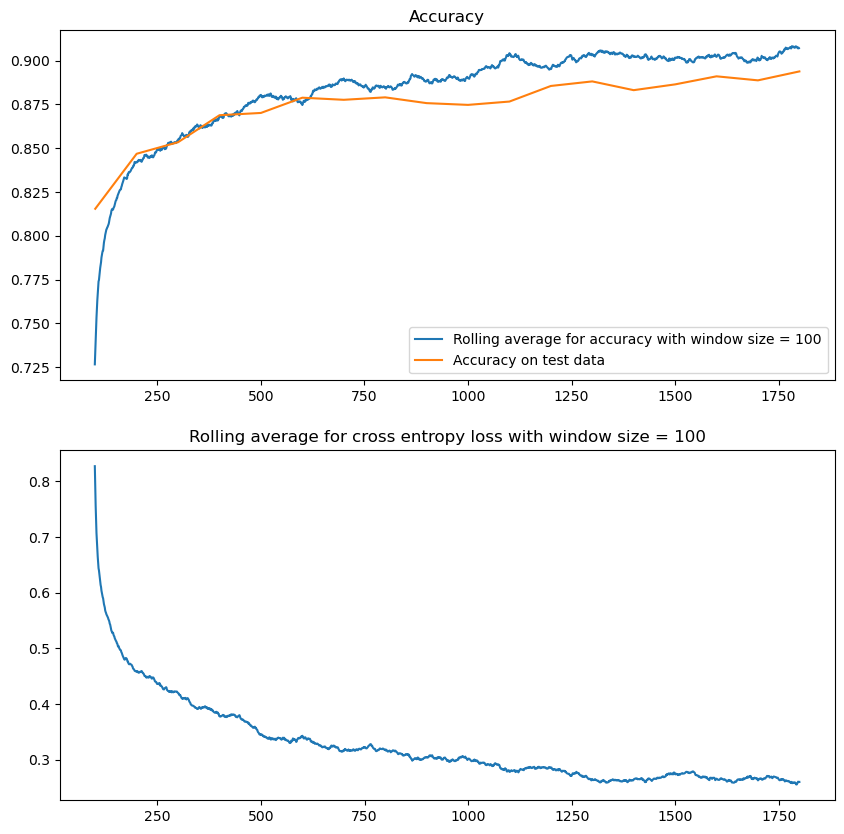

In [103]:
test_plus_plot(model,test_loader,train_ac_frozen, train_loss_frozen, test_ac_frozen )

### Test 5. Fashion-MNIST with unfrozen parametres on convolutional layer

In [104]:
model = MnistModel()
model.conv1.requires_grad_(False)
model.conv2.requires_grad_(False)
unfrozen_parametres = filter(lambda p: p.requires_grad, model.parameters())

model.load_state_dict(mnist_params)

train_ac_unfrozen_1, train_loss_unfrozen_1, test_ac_unfrozen_1 = train_model(model, optim.Adam(unfrozen_parametres, lr=0.001), train_loader, test_loader, 2)
model.conv1.requires_grad_(True)
model.conv2.requires_grad_(True)
train_ac_unfrozen_2, train_loss_unfrozen_2, test_ac_unfrozen_2 = train_model(model, optim.Adam(model.parameters(), lr=0.001), train_loader, test_loader, 3)


epoch 1/2
step 100/600	loss 0.5006	train_accuracy 0.81	test_accuracy 0.81
step 200/600	loss 0.5902	train_accuracy 0.78	test_accuracy 0.84
step 300/600	loss 0.3707	train_accuracy 0.88	test_accuracy 0.84
step 400/600	loss 0.4365	train_accuracy 0.84	test_accuracy 0.86
step 500/600	loss 0.2776	train_accuracy 0.93	test_accuracy 0.87
step 600/600	loss 0.2995	train_accuracy 0.91	test_accuracy 0.87
epoch 2/2
step 100/600	loss 0.3186	train_accuracy 0.85	test_accuracy 0.87
step 200/600	loss 0.3170	train_accuracy 0.89	test_accuracy 0.88
step 300/600	loss 0.3114	train_accuracy 0.86	test_accuracy 0.88
step 400/600	loss 0.2899	train_accuracy 0.86	test_accuracy 0.88
step 500/600	loss 0.2804	train_accuracy 0.92	test_accuracy 0.88
step 600/600	loss 0.2192	train_accuracy 0.90	test_accuracy 0.89
epoch 1/3
step 100/600	loss 0.2561	train_accuracy 0.88	test_accuracy 0.89
step 200/600	loss 0.4143	train_accuracy 0.86	test_accuracy 0.89
step 300/600	loss 0.2769	train_accuracy 0.91	test_accuracy 0.89
step 400/6

Accuracy on test data: 0.8994


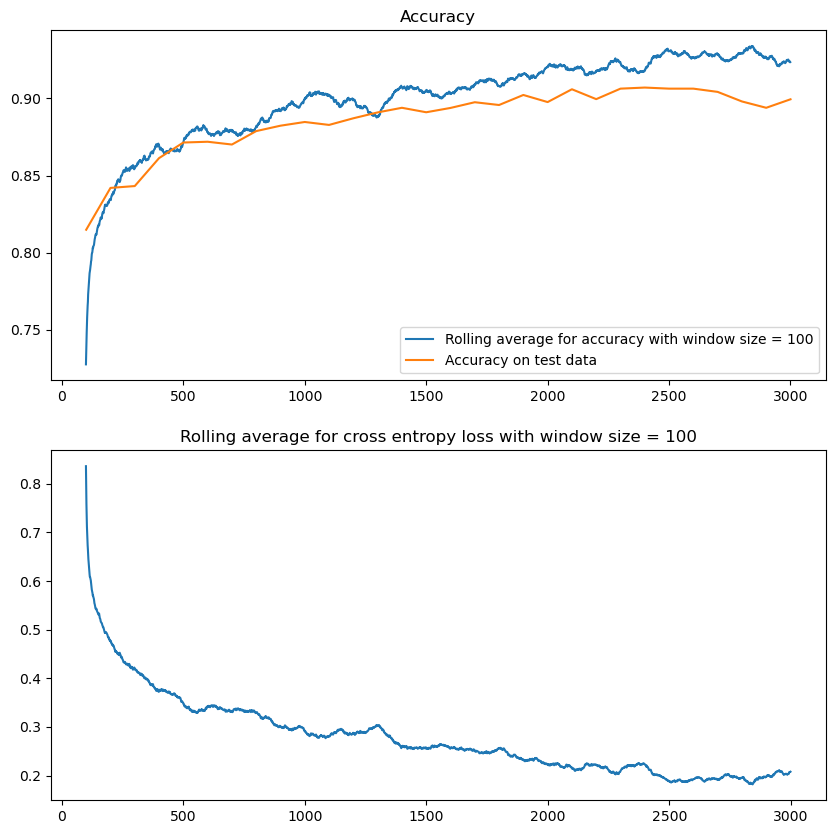

In [109]:
train_ac_unfrozen = train_ac_unfrozen_1 + train_ac_unfrozen_2
train_loss_unfrozen = train_loss_unfrozen_1 + train_loss_unfrozen_2
test_ac_unfrozen = test_ac_unfrozen_1 + test_ac_unfrozen_2
test_plus_plot(model,test_loader,train_ac_unfrozen, train_loss_unfrozen, test_ac_unfrozen )

### Analysis

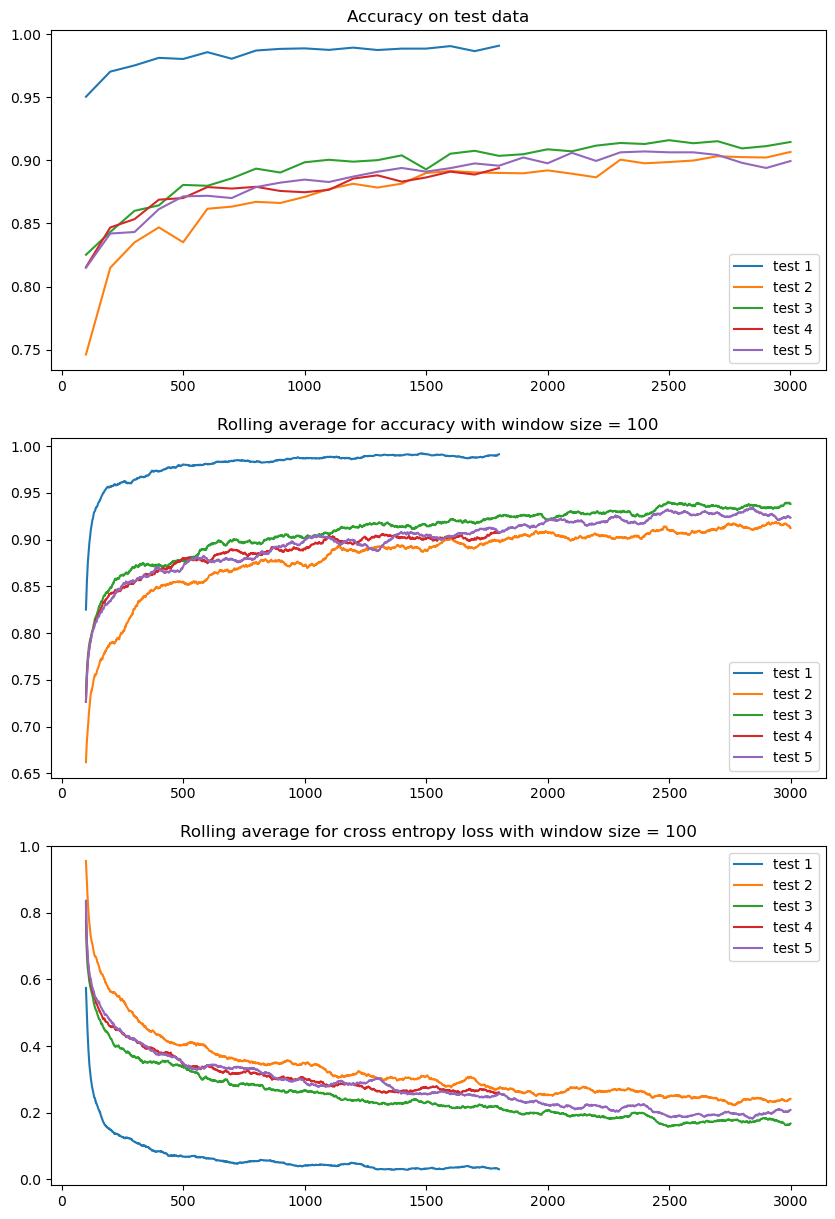

In [110]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
fig.set_size_inches(10,15)
window_size = 100

ax0.set_title("Accuracy on test data")
ax0.plot(range(batch_size,len(train_ac)+1,batch_size), test_ac, label="test 1")
ax0.plot(range(batch_size,len(train_ac_fashion)+1,batch_size), test_ac_fashion, label="test 2")
ax0.plot(range(batch_size,len(train_ac_fashion_copied)+1,batch_size), test_ac_fashion_copied, label="test 3")
ax0.plot(range(batch_size,len(train_ac_frozen)+1,batch_size), test_ac_frozen, label="test 4")
ax0.plot(range(batch_size,len(train_ac_unfrozen)+1,batch_size), test_ac_unfrozen, label="test 5")
ax0.legend()

ax1.set_title(f"Rolling average for accuracy with window size = {window_size}")
ax1.plot(pd.Series(train_ac).rolling(window_size).mean(), label="test 1")
ax1.plot(pd.Series(train_ac_fashion).rolling(window_size).mean(), label="test 2")
ax1.plot(pd.Series(train_ac_fashion_copied).rolling(window_size).mean(), label="test 3")
ax1.plot(pd.Series(train_ac_frozen).rolling(window_size).mean(), label="test 4")
ax1.plot(pd.Series(train_ac_unfrozen).rolling(window_size).mean(), label="test 5")
ax1.legend()

ax2.set_title(f"Rolling average for cross entropy loss with window size = {window_size}")
ax2.plot(pd.Series(train_loss).rolling(window_size).mean(), label="test 1")
ax2.plot(pd.Series(train_loss_fashion).rolling(window_size).mean(), label="test 2")
ax2.plot(pd.Series(train_loss_fashion_copied).rolling(window_size).mean(), label="test 3")
ax2.plot(pd.Series(train_loss_frozen).rolling(window_size).mean(), label="test 4")
ax2.plot(pd.Series(train_loss_unfrozen).rolling(window_size).mean(), label="test 5")
ax2.legend()

plt.show()